# Analytical Upwelling Model

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import sympy as sp

%matplotlib inline

plt.rcParams['font.size'] = 14

In [3]:
def make_domain_diagram(E=0.1, M=0.3, S=1.0):
    """Quick plotting code for a domain diagram
    """
    
    # Make figure
    fig, ax = plt.subplots(1, 1, figsize=(13, 5))
    ax.set_xlim([0, 1])
    ax.set_ylim([0, S])
    
    # Add labels
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.xaxis.set_ticks([0])
    ax.yaxis.set_ticks([0, M, S])
    ax.yaxis.set_ticklabels([0, 'M', 'S'])
    ax.tick_params(direction='out', pad=8)
    ax.text(-0.07, M/2-0.01, 'Cape')
    ax.text(1.01, S-0.01, 'Shelfbreak')
    
    # Add coastline ticks
    for tick in np.arange(0, 1, 0.01):
        ax.plot([tick, tick+0.01], [0, -0.02], 'k-', clip_on=False)
    for tick in np.arange(0, M, 0.03):
        ax.plot([-0.008, 0], [tick, tick+0.02], 'k-', clip_on=False)
        
    # Display SSH sink lengthscale
    ax.plot([0, 1], [E, E], 'k--')
    ax.text(1.01, E-0.01, 'E')

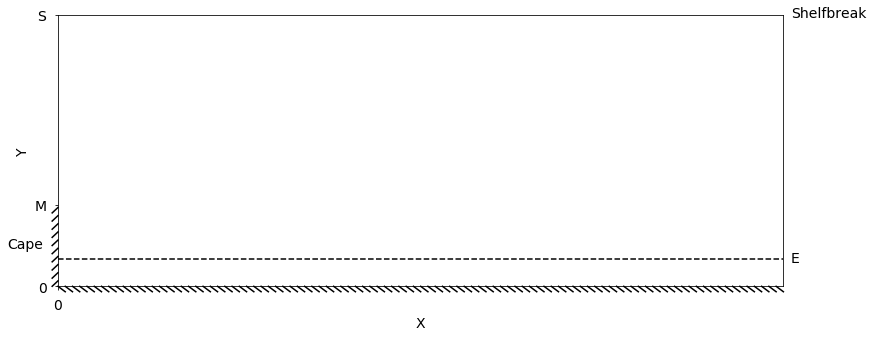

In [4]:
make_domain_diagram()

### Shallow water free surface equations for upwelling along a coastline

From Allen (1996), *JPO*:

The linear barotropic shallow water equations excluding the surface layer are

$$\begin{align}
\frac{\partial \mathbf{u}}{\partial t} + f\mathbf{k} \times \mathbf{u} & = -g\nabla\eta \tag{1a} \\
\frac{\partial \eta}{\partial t} + \nabla\cdot\left(h\mathbf{u}\right) & = -q \tag{1b}
\end{align}$$

where $q$ is the sea surface height sink due to Ekman pumping within a lengthscale $E$, given by

$$q =
  \begin{cases}
    q_0,  & \quad y > E\\
    0,    & \quad y < E
  \end{cases} \tag{2}
$$

and $q_0 = \tau/Ef$. A potential vorticity conservation equation can be derived

$$\frac{\partial}{\partial t}\left(h\nabla \times \mathbf{u} - f\eta\right) = f\mathbf{u}\cdot\nabla h + fq \tag{3}$$

Substituting constant and time-dependent solutions $\eta = \eta_1ft + \eta_0, \hspace{0.2cm} u = u_1ft + u_0, and \hspace{0.2cm} v = v_1ft + v_0$ into (1) and (3) gives, away from topographic changes

$$\begin{align}
a^2\nabla^2\eta_1 - \eta_1 & = \frac{q}{f} \tag{9} \\
a^2\nabla^2\eta_0 - \eta_0 & = 0 \tag{10}
\end{align}$$

where $a = \sqrt{gh}/f$ is the barotropic Rossby radius.

### Solution in absence of a cape

In the absence of a cape, (9) is $x$-independent and reduces to

$$\frac{gh}{f^2}\frac{\partial^2 \bar{\eta_1}(y)}{\partial y^2} - \bar{\eta_1}(y) = \frac{q}{f} \tag{A2}$$

Boundary conditions are

$$\begin{align}
& \frac{\partial \bar{\eta_1}(0)}{\partial y} = 0 \hspace{0.5cm} \text{(no flow along coastal boundary)} \tag{A3a} \\
& \bar{\eta_1}(E), \hspace{0.3cm} \frac{\partial \bar{\eta_1}(E)}{\partial y} \hspace{0.5cm} \text{continuous} \tag{A3b} \\
& \bar{\eta_1}(S), \hspace{0.3cm} h\frac{\partial \bar{\eta_1}(S)}{\partial y} \hspace{0.5cm} \text{continuous} \tag{A3c} \\
& \lim_{y \to \infty} \bar{\eta_1}(y) = 0 \hspace{0.5cm} \text{($\eta$ decays far from coast)} \tag{A3d}
\end{align}$$

The solution to (A2) given the boundary conditions (A3) is

$$\bar{\eta_1}(y) =
\begin{cases}
\frac{q_0}{f}\left(\frac{\alpha\sinh\left(\frac{S - E}{a_s}\right) + \cosh\left(\frac{S - E}{a_s}\right)}{\alpha\sinh\left(\frac{S}{a_s}\right) + \cosh\left(\frac{S}{a_s}\right)}\right)\cosh\left(\frac{y}{a_s}\right) - \frac{q_0}{f},  & \quad y < E \\
-\frac{q_0}{f}\left(\frac{\sinh\left(\frac{E}{a_s}\right)}{\alpha\sinh\left(\frac{S}{a_s}\right) + \cosh\left(\frac{S}{a_s}\right)}\right)\left[\alpha\cosh\left(\frac{S - y}{a_s}\right) + \sinh\left(\frac{S - y}{a_s}\right)\right],  & \quad E < y < S
\end{cases} \tag{A4}
$$

The calculation is shown below

In [38]:
# Physical parameters
g = 9.81    # Gravitational acceleration [m/s2]
f = 1e-4    # Coriolis parameter         [1/s]
tau = 0.1   # Windstress                 [N/m2]
H_s = 1e2   # Depth over shelf           [m]
H_d = 2e3   # Depth beyond shelfbreak    [m]

# Domain parameters
E = 5e4     # Upwelling lengthscale      [m]
S = 6e5     # Shelf width                [m]

# Calculate terms
a_s = np.sqrt(g * H_s) / f  # Rossby radius [m]
alpha = np.sqrt(H_s / H_d)  # Depth ratio
q_0 = tau / (E * f)         # Ekman pumping [m/s]

# Primary cosh and sinh terms
top = alpha * np.sinh((S - E) / a_s) + np.cosh((S - E) / a_s)
bot = alpha * np.sinh(S / a_s) + np.cosh(S / a_s)

# Make y array
y = np.arange(0, S, 1e3)

# Calculate eta_bar
eta_bar_near = q_0 / f * (top / bot * np.cosh(y / a_s) - 1)
eta_bar_far = -q_0 / f * np.sinh(E / a_s) / bot * (alpha * np.cosh((S - y) / a_s) + np.sinh((S - y) / a_s))
eta_bar = eta_bar_far
eta_bar_far[y <= E] = eta_bar_near[y <= E]

And plotted

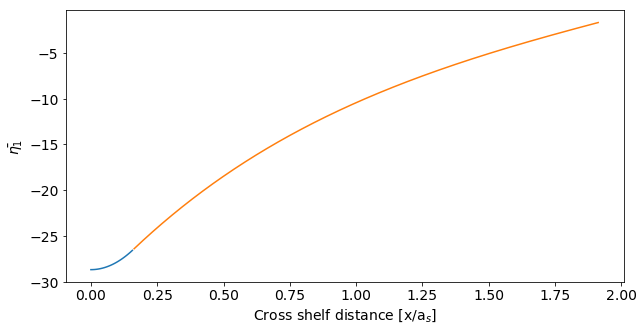

In [39]:
# Plot eta_bar
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.plot(y[y < E] / a_s, eta_bar_near[y < E])
ax.plot(y[y > E] / a_s, eta_bar_far[y > E])
ax.set_xlabel('Cross shelf distance [x/a$_s$]')
ax.set_ylabel('$\\bar{\eta_1}$')

plt.show()

### Solution of time-varying component

The full solution to (9) can be decomposed into a particular solution given by $\bar{\eta_1}(y)$ and a homogeneous solution $\phi$

$$\eta_1 = \bar{\eta_1}(y) + \phi \tag{12}$$

where $\phi$ satisfies the equation

$$\nabla^2\phi - \phi = 0 \tag{13}$$

Boundary conditions are

$$
\begin{align}
\phi(0) = \phi(S) & = 0 \hspace{0.5cm} \text{($x$-independent at coast and shelfbreak)} \tag{14a} \\
\lim_{x \to \infty}\phi & = 0 \hspace{0.5cm} \text{($x$-independent away from cape)} \tag{14b} \\
\phi(0, [0, M]) & = \bar{\eta_1}(0) - \bar{\eta_1}(y) \hspace{0.5cm} \text{(no flow through cape)} \tag{14c} \\
\frac{\partial}{\partial x}\phi(0, [M, S]) & = 0 \hspace{0.5cm} \text{(flow around cape is symmetric)} \tag{14d}
\end{align}
$$

The general solution to (13) given the $y$ boundary conditions (14a and b) is

$$\phi = \sum_{n=1}^\infty c_n\exp\left\{-x\left[1 + \left(\frac{n\pi}{S}\right)^2\right]^{1/2}\right\}\sin\left(\frac{n\pi y}{S}\right) \tag{15, 16}$$

Applying the $x = 0$ boundary conditions

$$
\begin{align}
\phi(0, y) = & \sum_{n=1}^\infty c_n\sin\left(\frac{n\pi y}{S}\right) = \frac{q_0}{f}\left(\frac{\alpha\sinh\left(\frac{S - E}{a_s}\right) + \cosh\left(\frac{S - E}{a_s}\right)}{\alpha\sinh\left(\frac{S}{a_s}\right) + \cosh\left(\frac{S}{a_s}\right)}\right)\left[1 - \cosh\left(\frac{y}{a_s}\right)\right] & \hspace{0.2cm} \text{for } y = [0, M] \\
\frac{\partial}{\partial x}\phi(0, y) = & \sum_{n=1}^\infty -c_n\left[1 + \left(\frac{n\pi}{S}\right)^2\right]^{1/2}\sin\left(\frac{n\pi y}{S}\right) = 0 & \hspace{0.2cm} \text{for } y = [M, S]
\end{align}$$

Now we calculate phi and eta

In [43]:
# Parameters
N = 50
M = E

# Define y arrays
N_cape = int(N * M / S)
N_water = N - N_cape
y_cape = np.arange(1, N_cape + 1) / N_cape * M
y_water = np.arange(N_water) / (N_water - 1) * (S - M) + M

# Allocate matrix A
A = np.empty([0, N])
RHS = np.zeros([N, 1])

# Populate A and RHS near cape (0 to M)
for i, yi in enumerate(y_cape):
    A = np.vstack([A, np.array([np.sin(n * np.pi / S * yi) for n in range(1, N + 1)])])
    RHS[i] = q_0 / f * top / bot * (1 - np.cosh(yi / a_s))

# Populate A over water (M to S)
for yi in y_water:
    A = np.vstack([A, np.array([-np.sqrt(1 + (n * np.pi / S)**2) * np.sin(n * np.pi / S * yi) for n in range(1, N + 1)])])
    
# Solve for C coefficients
C = np.linalg.solve(A, RHS)

# Calculate phi
x = np.arange(0, 100, 1)
x, y = np.meshgrid(x, y)
phi = np.zeros(x.shape)
for n, C_n in zip(range(N), C):
    phi = phi + C_n * np.exp(-x * np.sqrt(1 + (n * np.pi / S)**2)) * np.sin(n * np.pi / S * y)

# Calculate eta
eta = phi + eta_bar[:, np.newaxis] * np.ones(x.shape)

And plot

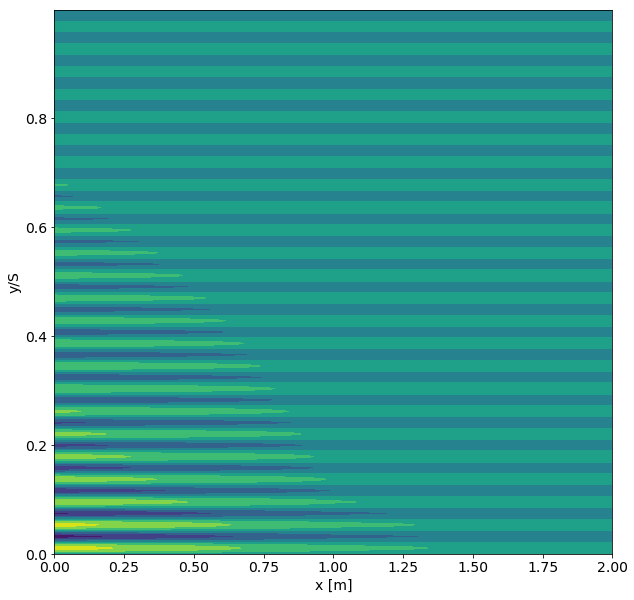

In [44]:
# Plot eta_bar
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.contourf(x, y/S, phi)
ax.set_xlim([0, 2])
ax.set_xlabel('x [m]')
ax.set_ylabel('y/S')

plt.show()